# Understanding Word Embeddings and Bias in Modern Natural Language Processing (NLP)

Word embeddings are foundational tools in modern natural language processing (NLP). They allow us to represent words as dense, continuous-valued vectors in a high-dimensional space, where semantic relationships are captured through vector similarity and direction. For example, embeddings can model analogies such as:

$$
\text{“king”} - \text{“man”} + \text{“woman”} \approx \text{“queen”} 
$$

Rather than training word embeddings from scratch—which would require massive datasets and computational power—we typically rely on **pretrained embeddings** (e.g., GloVe, Word2Vec, fastText) trained on large corpora such as Wikipedia or Common Crawl. These embeddings are widely used as input features for various NLP tasks, including sentiment analysis, named entity recognition, and machine translation.

However, since these embeddings are trained on real-world data, they often inherit and amplify **societal biases** present in the text. This introduces fairness and ethical concerns when embeddings are used in downstream applications. Understanding how these biases arise, and how to mitigate them through techniques like **Hard Debiasing**, is essential for building more responsible NLP systems.


## Table of Contents

- [1 - Packages](#1---Packages)
- [2 - Load the Word Vectors](#2---Load-the-Word-Vectors)
    - [2.1 - Embedding Visualization](#2.1---Embedding-Visualization)
- [3 - Similarity Measure](#3---Similarity-Measure)
    - [3.1 - Cosine Similarity](#3.1---Cosine-Similarity)
    - [3.2 - More Complex Relationships](#3.2---More-Complex-Relationships)
    - [3.3 - From Similarity to Visualization with t-SNE](#3.3---Similarity-to-Visualization-with-t-SNE)
- [4 - Word Analogy](#4---Word-Analogy)
    - [4.1 - Underlying Biases](#4---Underlying-Biases)
- [5 - Debiasing Word Vectors with Hard Debiasing](#5---Debiasing-Word-Vectors-with-Hard-Debiasing)
    - [5.1 - Bias Direction](#5.1---Bias-Direction)
    - [5.2 - Inspecting Names Along the Gender Direction](#5.2---Inspecting-Names-Along-the-Gender-Direction)
    - [5.3 - Inspecting Other Words and Their Similarities with the Gender Direction](#5.3---Inspecting-Other-Words-and-Their-Similarities-with-the-Gender-Direction)
    - [5.4 - Neutralizing Bias in Non-Gendered Words](#5.4---Neutralizing-Bias-in-Non-Gendered-Words)
        - [5.4.1 - Step-by-Step: Neutralizing a Word Vector](#5.4.1---Step-by-Step:-Neutralizing-a-Word-Vector)
    - [5.5 - Equalization Algorithm for Gender-Specific Words](#5.5---Equalization-Algorithm-for-Gender-Specific-Words)
        - [5.5.1 - Step-by-Step: Equalization a Word Vector](#5.5.1---Step-by-Step:-Equalization-a-Word-Vector)
- [6 - Inspecting Names After Debiasing](#6---Inspecting-Names-After-Debiasing)
- [7 - Inspecting Words After Debiasing](#7---Inspecting-Words-After-Debiasing)


---

<a name='1'></a>
## 1 - Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from utils import *

---

<a name='2'></a>
## 2 - Load the Word Vectors

For this project, we will use a pre-trained word embedding representation of the GloVe algorithm with 400k words that are embedded in a 50-dimensional representation. So, the file `data/glove.6B.50d.txt` includes a word per line followed by its vector embedding. Here, we simple open the file and load the unique words in a set and their embeddings in a dictionary for easy access.

In [2]:
vocab, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

<a name='2.1'></a>

### 2.1 - Embedding Visualization

In `word_to_vec_map`, each word is represented as a 50-dimensional vector. Since it's difficult to interpret all 50 values directly, we’ll display only the **first 5 dimensions** of each embedding for simplicity.

The selected words are: `cat`, `sheep`, `man`, `woman`, `orange`, and `apple`. These examples include animals, people, and fruits—allowing us to observe how similar concepts cluster in the embedding space.

In [3]:
for w in ['cat', 'sheep', 'man', 'woman', 'orange', 'apple']:
    if w not in vocab: continue
    print(w, word_to_vec_map[w][:5])

cat [ 0.45281  -0.50108  -0.53714  -0.015697  0.22191 ]
sheep [ 0.39026 -1.1357  -0.47646 -1.0185   0.44893]
man [-0.094386  0.43007  -0.17224  -0.45529   1.6447  ]
woman [-0.18153  0.64827 -0.5821  -0.49451  1.5415 ]
orange [-0.42783   0.43089  -0.50351   0.5776    0.097786]
apple [ 0.52042 -0.8314   0.49961  1.2893   0.1151 ]


---

<a name='3'></a>

## 3 - Similarity Measure

The power of word embeddings lies in their ability to generalize and represent semantic relationships between words. A well-trained embedding model tends to place similar concepts closer together in the vector space. For example, the embeddings of **boy** and **man** should be relatively close to each other, just as **girl** and **woman** should be. One way to explore this idea is by measuring the similarity between two words through their embedding vectors.

To assess similarity between two words, we use a mathematical measure that quantifies the closeness between their embedding vectors. Common similarity measures include **Cosine similarity**, **Euclidean distance**, **Manhattan distance**, and **Chebyshev distance**. While different similarity functions can be used, **cosine similarity** is often preferred.

<a name='3.1'></a>

### 3.1 - Cosine Similarity

Given two vectors $u$ and $v$, **cosine similarity** is defined as:

$$
\text{CosineSimilarity}(u, v) = \frac {u \cdot v} {\|u\|_2 \|v\|_2} = \cos(\theta) \tag{1}
$$
where:

* $u \cdot v$ is the **dot product** of the vectors.
* $\|u\|_2$ is the **Euclidean norm** (or length) of vector $u$, given by $\sqrt{\sum_{i=1}^{n} u_i^2}$.
* $\theta$ is the **angle** between vectors $u$ and $v$.

Interpretation:

* If $u$ and $v$ are **very similar**, the angle $\theta$ between them is small, and the cosine similarity is close to **1**.
* If $u$ and $v$ are **dissimilar**, the angle is larger, and the cosine similarity decreases toward **0** (or even **-1** for opposite directions).

<br>

<img src="images/cosine_sim.png">
<caption><center><font color='blue'><b>Figure 1</b>: The cosine of the angle between two vectors is a measure of their similarity. Image retrieve from the Deep Learning Specialization by Prof. Andrew Ng.</font></center></caption>

<a name='3.1.1'></a>

### 3.1.1 - Evaluating Similarity Pairs

In [4]:
pairs = [
    ('cat', 'sheep'), 
    ('man', 'boy'), 
    ('woman', 'girl'), 
    ('man', 'woman'), 
    ('orange', 'apple'), 
    ('cat', 'man'), 
    ('sheep', 'woman')
]

for word1, word2 in pairs:    
    print(f'cosine_similarity({word1}, {word2}): {cosine_similarity(word_to_vec_map[word1], word_to_vec_map[word2])}')

cosine_similarity(cat, sheep): 0.6291239695676666
cosine_similarity(man, boy): 0.8564431790318322
cosine_similarity(woman, girl): 0.9065280671323898
cosine_similarity(man, woman): 0.886033771849582
cosine_similarity(orange, apple): 0.5388040721946523
cosine_similarity(cat, man): 0.6240708914812086
cosine_similarity(sheep, woman): 0.3320790184563425


<a name='3.2'></a>

### 3.2 - More Complex Relationships

To explore more complex relationships between words, one common technique is to analyze **vector differences** between related words.

For example, the relationship between **'grandfather'** and **'father'** can be captured by the difference of their embeddings. Similarly, the difference between **'grandmother'** and **'mother'** should be similar. By subtracting word vectors, we aim to uncover the underlying semantic relationship (e.g., generational or gender-based shifts).

This idea is central to many famous examples in word embeddings, such as:

$$
\text{vec}(\text{"king"}) - \text{vec}(\text{"man"}) + \text{vec}(\text{"woman"}) \approx \text{vec}(\text{"queen"})  \tag{2}
$$

These vector arithmetic operations demonstrate that word embeddings can encode not just similarity, but **relational structure**—allowing us to reason analogically in the embedding space.


In [5]:
tuples_to_try = [
    ('king', 'man', 'woman', 'queen'),
    ('dad', 'man', 'woman', 'mother')
]

for tuples in tuples_to_try:
    result = cosine_similarity(word_to_vec_map[tuples[0]] - word_to_vec_map[tuples[1]] + word_to_vec_map[tuples[2]], word_to_vec_map[tuples[3]])
    print(f"cosine_similarity({tuples[0]} - {tuples[1]} + {tuples[2]}, {tuples[3]}) -> {result}")

cosine_similarity(king - man + woman, queen) -> 0.8609581258578943
cosine_similarity(dad - man + woman, mother) -> 0.837962108146877


<a name='3.3'></a>

### 3.3 - Similarity Visualization with t-SNE

To build an intuitive understanding of how word embeddings cluster semantically similar words together, we can visualize them in two dimensions.

Since word embeddings typically exist in a high-dimensional space (e.g., 50 or 300 dimensions), we use dimensionality reduction techniques to project them onto a 2D plane. One of the most effective tools for this is **t-distributed Stochastic Neighbor Embedding (t-SNE)**. 

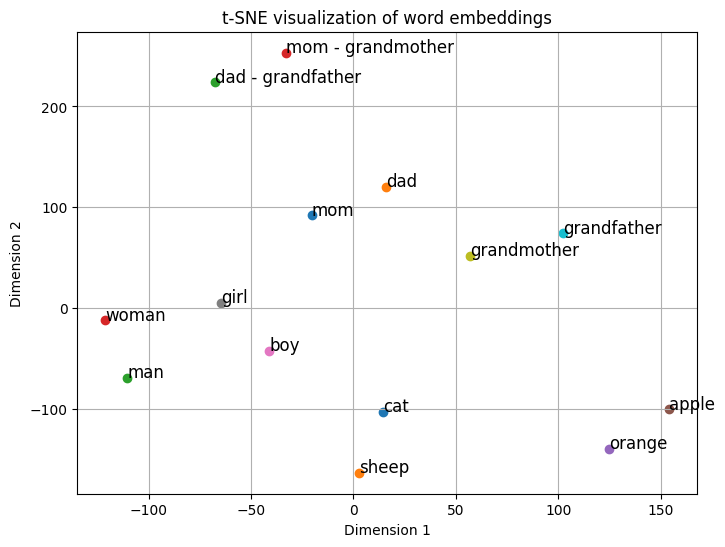

In [6]:
words = ['cat', 'sheep', 'man', 'woman', 'orange', 'apple', 'boy', 'girl', 'grandmother', 'grandfather', 'mom', 'dad']
X = [word_to_vec_map[w] for w in words]

# adding more complex relationships
words = words + ['dad - grandfather', 'mom - grandmother']
X.append(word_to_vec_map['dad'] - word_to_vec_map['grandfather'])
X.append(word_to_vec_map['mom'] - word_to_vec_map['grandmother'])

tsne = TSNE(n_components = 2, random_state = 0, perplexity = 5)
embeds_2d = tsne.fit_transform(np.array(X))

plot_tsne(words, embeds_2d)

**Intuition:** Notably, **`cat` and `sheep`** appear close together in the 2D space, as do **`apple` and `orange`**, and **`woman` and `man`**, reflecting their semantic similarity in the original high-dimensional embedding space.

---

<a name='4'></a>

## 4 - Word Analogy

We can generalize the idea of semantic relationships through the **word analogy task**.

* The task involves completing a sentence of the form: <font color='blue'>"*a* is to *b* as *c* is to **\_\_\_\_**"</font>

* A classic example: <font color='blue'>"*man* is to *woman* as *king* is to *queen*"</font>

In the word embedding space, we aim to find a word *d* such that the word vectors $e_a, e_b, e_c, e_d$ satisfy Equation (2). In other words, we want:

$$
e_d \approx e_b - e_a + e_c \tag{3}
$$

That is, we can estimate the vector $e_d$ and search for the closest actual word vector in the vocabulary using **cosine similarity**.

In [7]:
triads_to_try = [
    ('england', 'english', 'brazil'),
    ('man', 'woman', 'boy'),
    ('small', 'smaller', 'large'),
    ('paris', 'france', 'rome')
]

for triad in triads_to_try:
    result = word_analogy(*triad, word_to_vec_map = word_to_vec_map, vocab = vocab)
    print(f"{triad[0]} -> {triad[1]} :: {triad[2]} -> {result}")

england -> english :: brazil -> brazilian
man -> woman :: boy -> girl
small -> smaller :: large -> larger
paris -> france :: rome -> italy


**Intuition:**

Some of these analogies often make a lot of sense! 

However, **england** → **english** :: **brazil** → **brazilian** is not entirely accurate — a more precise analogy might be **brazil** → *brazilian portuguese*. Still, the predicted word is often "close enough" to reflect meaningful associations.


<a name='4.1'></a>

### 4.1 - Underlying Biases

However, not all analogies are this clean. Some reflect **underlying biases** present in the training data. For example, analogies involving *gender*, *professions*, or *race* may reinforce harmful stereotypes rather than neutral patterns. Let's take a look at a two examples that illustrate this a gender bias issue.

In [8]:
biased_triads = [
    ('man', 'engineer', 'woman'),
    ('man', 'doctor', 'woman'),
]

for triad in biased_triads:
    result = word_analogy(*triad, word_to_vec_map = word_to_vec_map, vocab = vocab)
    print(f"{triad[0]} -> {triad[1]} :: {triad[2]} -> {result}")

man -> engineer :: woman -> technician
man -> doctor :: woman -> nurse


To address biases embedded in word vectors, researchers have proposed various **debiasing techniques**. One well-known approach is **Hard Debiasing**, discussed in the following sections.

---

<a name='5'></a>

## 5 - Debiasing Word Vectors with Hard Debiasing

The Hard Debiasing process consists of three main steps:

1. **Identifying a bias direction** (e.g., the gender direction) by computing a vector that captures the concept of bias.
2. **Neutralizing** the bias in words that should be gender-neutral (e.g., *doctor*, *nurse*, *scientist*) by removing their component along the bias direction.
3. **Equalizing** gendered word pairs (e.g., *“grandmother”* and *“grandfather”*) so that they are equidistant from neutral concepts.

<a name='5.1'></a>

### 5.1 - Bias Direction


We can explore how **GloVe word embeddings** represent gender. One simple way to do this is by computing the **gender direction** as:

$$
g = e_{\text{woman}} - e_{\text{man}} \tag{4}
$$

where $e_{\text{woman}}$ and $e_{\text{man}}$ are the embeddings for *woman* and *man*, respectively. This vector $g$ captures a rough representation of gender in the embedding space.

For a more robust estimate, we could average multiple gender-related differences, such as:

$$
g_1 = e_{\text{mother}} - e_{\text{father}}, \quad g_2 = e_{\text{girl}} - e_{\text{boy}}, \quad {etc.} \tag{5}
$$

However, using just $e_{\text{woman}} - e_{\text{man}}$ is sufficient for many exploratory tasks and provides a good approximation of the gender subspace.

In [9]:
gender_pairs = [
    ('woman', 'man'),
    ('mother', 'father'),
    ('girl', 'boy'),
    ('she', 'he'),
    ('daughter', 'son'),
    ('female', 'male'),
    ('her', 'his'),
    ('niece', 'nephew'),
    ('aunt', 'uncle'),
    ('grandmother', 'grandfather')
]

# compute individual difference vectors
g_list = [word_to_vec_map[f] - word_to_vec_map[m] for f, m in gender_pairs]

# average them to get the gender direction
g = np.mean(g_list, axis=0)

# normalize the vector (optinal)
g = g / np.linalg.norm(g)

# g is now your gender direction vector
print(g)

[ 0.07336785  0.16489635 -0.13490301  0.01259356 -0.05408367  0.28391044
  0.00897629  0.04036826  0.25949707 -0.07046061 -0.02264035 -0.20175986
  0.25675982  0.08015372  0.10978476  0.04278409 -0.24423643 -0.05215302
  0.26257189 -0.01549941  0.113364    0.29236928  0.07361009  0.13418695
  0.15204449  0.08833872 -0.06920823  0.18931872  0.0280845  -0.21813619
 -0.09666052  0.14964541  0.07203181  0.0270664  -0.08148077 -0.07071291
 -0.06138797 -0.03807559  0.0768596  -0.22137245 -0.03188453 -0.09391473
  0.28425201 -0.18623102  0.01401433 -0.09063985  0.13675838 -0.15753885
  0.0309212   0.05656646]


<a name='5.2'></a>

### 5.2 - Inspecting Names Along the Gender Direction

Once we have the gender direction vector $g$, we can examine how strongly different names align with it. Below, we compute the **cosine similarity** between each name’s embedding and the gender direction. A positive similarity suggests alignment with the female direction, while a negative one suggests alignment with the male direction.

In [10]:
print ('List of names and their similarities with constructed vector:')

# girls and boys name
name_list = [
    'emma',     # female
    'liam',     # male
    'olivia',   # female
    'noah',     # male
    'fatima',   # female
    'ahmed',    # male
    'hana',     # female
    'mohammed', # male
    'lucia',    # female
    'carlos',   # male
    'ananya',   # female
    'arjun',    # male
    'sofia',    # female
    'kevin',    # male
    'nina',     # female
    'jacob',    # male
    'chiara',   # female (Italian)
    'hiroshi',  # male (Japanese)
    'leila',    # female (Persian/Arabic)
    'omar'      # male (Arabic)
]

for w in name_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

List of names and their similarities with constructed vector:
emma 0.4364690129995367
liam -0.05496401597006431
olivia 0.3290723713475616
noah -0.02727317338628937
fatima 0.22448654171207402
ahmed -0.22846722117077348
hana 0.38027427026126415
mohammed -0.34174291081225605
lucia 0.26566567058234297
carlos -0.24291298322050836
ananya 0.20666545477883805
arjun 0.05038626829497463
sofia 0.16121005676532355
kevin -0.2009401289514348
nina 0.40915235779400533
jacob -0.20164050749841994
chiara 0.3054608000338558
hiroshi -0.031869486673264245
leila 0.22022968585449493
omar -0.35574527274694584


<a name='5.3'></a>

### 5.3 - Inspecting Other Words and Their Similarities with the Gender Direction



In [ ]:
print("Other words and their similarities with the gender direction vector:\n")

word_list = [
    'lipstick', 'guns', 'science', 'arts', 'literature', 'warrior',
    'doctor', 'tree', 'receptionist', 'technology', 'fashion',
    'teacher', 'engineer', 'pilot', 'computer', 'singer',
    'nurse', 'soldier', 'kitchen', 'mathematics'
]

for w in word_list:
    val = cosine_similarity(word_to_vec_map[w], g)
    biased_embedding = 'Male' if val < 0 else 'Female'
    print(f"{w:<15s}: {val:+.4f} ({biased_embedding})")

Other words and their similarities with the gender direction vector:

lipstick       : +0.4642 (Female)
guns           : -0.1404 (Male)
science        : -0.0817 (Male)
arts           : -0.0332 (Male)
literature     : -0.0614 (Male)
warrior        : -0.2081 (Male)
doctor         : +0.0738 (Female)
tree           : +0.0568 (Female)
receptionist   : +0.3802 (Female)
technology     : -0.1568 (Male)
fashion        : +0.1337 (Female)
teacher        : +0.0536 (Female)
engineer       : -0.2546 (Male)
pilot          : -0.0355 (Male)
computer       : -0.1285 (Male)
singer         : +0.2035 (Female)
nurse          : +0.3619 (Female)
soldier        : -0.0192 (Male)
kitchen        : +0.1408 (Female)
mathematics    : -0.1949 (Male)


<a name='5.4'></a>

### 5.4 – Neutralizing Bias in Non-Gendered Words

We now aim to remove gender bias from words that **should be neutral** (like *doctor*, *receptionist*, *scientist*, etc.). This is done using a process called **neutralization**, which removes the component of a word vector along the **bias direction** $g$.

<a name='5.4.1'></a>

#### 5.4.1 – Step-by-Step: Neutralizing a Word Vector

Let’s say we want to debias the word “receptionist.” Here's how the process works:

1. **Get the word vector**
   Retrieve the original embedding $e$ of the word (e.g., `word_to_vec_map['receptionist']`).

2. **Compute the projection onto the bias direction**
   Use the formula for vector projection to compute how much of $e$ lies in the direction of the gender bias vector $g$:

   $$
   e^{\text{bias\_component}} = \frac{e \cdot g}{\|g\|^2} \cdot g
   $$

3. **Subtract the bias component**
   Remove the gender component from $e$ by subtracting the projection:

   $$
   e^{\text{debiased}} = e - e^{\text{bias\_component}}
   $$

4. **(Optional) Normalize the result**
   You may want to normalize $e^{\text{debiased}}$ to maintain consistency across vector magnitudes.

In [12]:
# normalized all word embeddings:
from tqdm import tqdm
word_to_vec_map_unit_vectors = {
    word: embedding / np.linalg.norm(embedding)
    for word, embedding in tqdm(word_to_vec_map.items())
}

# built a list of gender direction vectors:
g_list = [
    word_to_vec_map_unit_vectors[f] - word_to_vec_map_unit_vectors[m]
    for f, m in gender_pairs
]

# averaged those directions into a single vector g_unit:
g_unit = np.mean(g_list, axis=0)

# normalized g_unit so it becomes a unit vector:
g_unit = g_unit / np.linalg.norm(g_unit)

word = "receptionist"
print("cosine similarity between " + word + " and g, before neutralizing: ", cosine_similarity(word_to_vec_map[word], g))

e_debiased = neutralize(word, g_unit, word_to_vec_map_unit_vectors)
print("cosine similarity between " + word + " and g_unit, after neutralizing: ", cosine_similarity(e_debiased, g_unit))

100%|██████████| 400000/400000 [00:03<00:00, 121244.78it/s]

cosine similarity between receptionist and g, before neutralizing:  0.38022007647892747
cosine similarity between receptionist and g_unit, after neutralizing:  -1.5573683486072468e-16


<a name='5.5'></a>

### 5.5 – Equalization Algorithm for Gender-Specific Words

After neutralizing bias in gender-neutral words, the next step is **equalization** — applied to **pairs of gender-specific words** like *“actress”* and *“actor”*.

Consider this example:
Suppose *“actress”* is closer to *“babysit”* than *“actor”* is. While neutralizing *“babysit”* removes its gender bias, it does not ensure *“actress”* and *“actor”* are equally related to *“babysit”*. The **equalization algorithm** fixes this by making the two gendered words **equidistant from any neutral word** in the space orthogonal to the gender direction.


<a name='5.5.1'></a>
#### 5.5.1 – Step-by-Step: Equalization a Word Vector

1. The embedding space is decomposed into the **bias direction** $g$ and its orthogonal complement $g_{\perp}$.
2. Equalization ensures that a gender pair $(e_{w1}, e_{w2})$ differ **only along the bias direction**, and are symmetric with respect to the neutral subspace.
3. This means both words become the same distance from the neutral embeddings, like $e_{\text{receptionist}}^{\text{debiased}}$.

In [13]:
print("Cosine similarities before equalizing:")
print("cosine_similarity(word_to_vec_map_unit_vectors[\"man\"], g_unit) =", cosine_similarity(word_to_vec_map_unit_vectors["man"], g_unit))
print("cosine_similarity(word_to_vec_map_unit_vectors[\"woman\"], g_unit) =", cosine_similarity(word_to_vec_map_unit_vectors["woman"], g_unit))
print()

e1, e2 = equalize(("man", "woman"), g_unit, word_to_vec_map_unit_vectors)

print("Cosine similarities after equalizing:")
print("cosine_similarity(e1, g_unit) =", cosine_similarity(e1, g_unit))
print("cosine_similarity(e2, g_unit) =", cosine_similarity(e2, g_unit))

Cosine similarities before equalizing:
cosine_similarity(word_to_vec_map_unit_vectors["man"], g_unit) = -0.10776868515738063
cosine_similarity(word_to_vec_map_unit_vectors["woman"], g_unit) = 0.2826303254002103

Cosine similarities after equalizing:
cosine_similarity(e1, g_unit) = -0.2542189260899196
cosine_similarity(e2, g_unit) = 0.25421892608991964


[[-5.13897810e-02  4.61951033e-02 -2.35245725e-02 -9.59056613e-02
   3.22674341e-01  6.79007361e-02 -8.23249608e-02  6.57345228e-02
  -6.78695436e-02  1.10419087e-02  1.76963311e-02  2.26146969e-02
  -1.24523627e-01  7.50803155e-02  9.89374044e-02 -9.32917529e-02
   1.01267199e-02  1.21050582e-01 -1.59512831e-01  4.98868957e-02
  -1.65897229e-01  1.87387072e-01 -2.80895286e-02  4.69038649e-02
   5.19817725e-02 -5.52902465e-01 -1.16142230e-01  7.19318489e-04
   4.61223853e-02  1.49397415e-02  5.02052769e-01 -1.11684355e-01
  -6.99915321e-02  1.38916006e-02  7.59776095e-02  6.45367545e-02
   3.04798421e-02  1.64785951e-02  2.67261354e-02 -5.61180936e-02
  -2.05459468e-02  1.32345245e-01 -6.24735174e-02  9.14683680e-02
   1.12814287e-01 -9.93370236e-02 -1.15708102e-01 -1.68801208e-01
   8.39297146e-02 -3.93617606e-02]
 [-1.25323033e-02  1.24990205e-01 -9.06449117e-02 -8.37784814e-02
   2.81567558e-01  2.03593928e-01 -7.04775633e-02  8.09705164e-02
   6.55663893e-02 -2.37111494e-02  3.0022

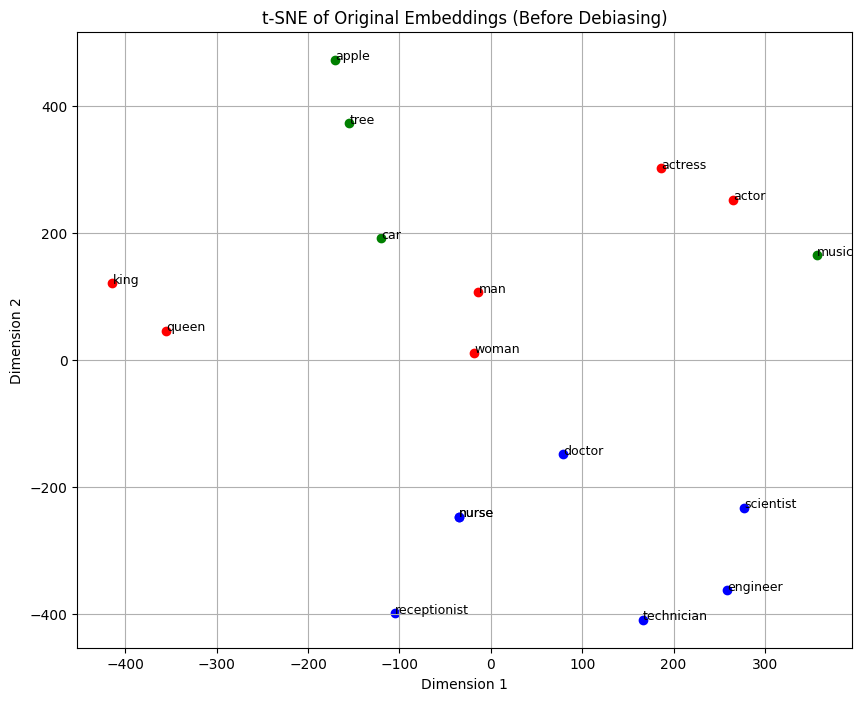

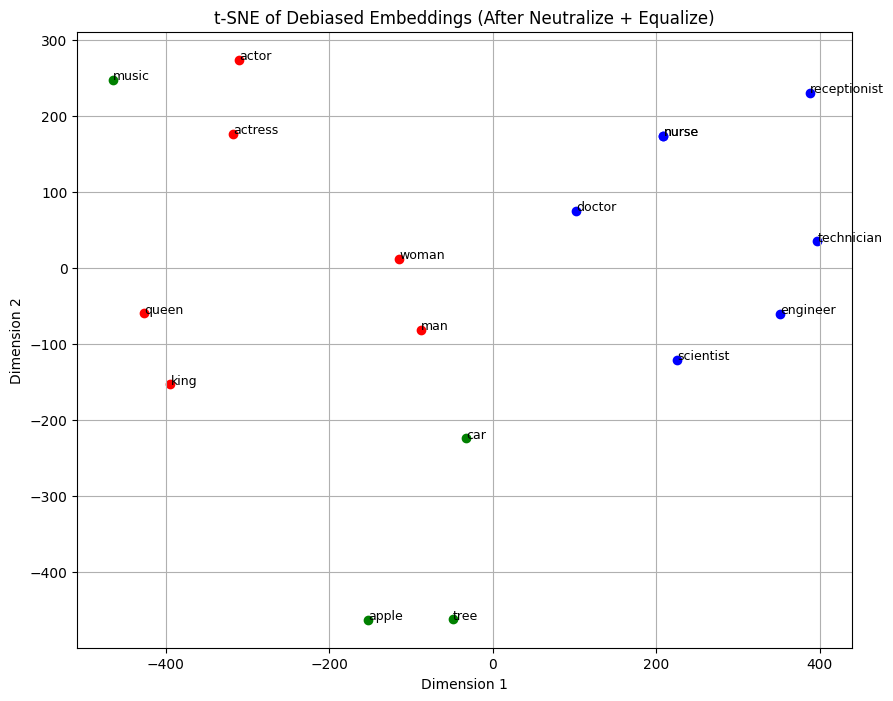

In [ ]:
# example words (you can extend this list)
gender_pairs = [("man", "woman"), ("king", "queen"), ("actor", "actress")]
neutral_words = ["receptionist", "scientist", "nurse", "engineer", 'doctor', 'technician', 'nurse']
other_words = ["apple", "car", "tree", "music"]

words = [w for pair in gender_pairs for w in pair] + neutral_words + other_words

# 1. Original embeddings (unit vectors)
original_embeds = np.array([word_to_vec_map_unit_vectors[w] for w in words])

# 2. Debiasing embeddings
# Neutralize neutral words
debias_embeds = []
for w in words:
    if w in neutral_words:
        debias_embeds.append(neutralize(w, g_unit, word_to_vec_map_unit_vectors))
    else:
        debias_embeds.append(word_to_vec_map_unit_vectors[w])
debias_embeds = np.array(debias_embeds)

# Equalize gender pairs
for w1, w2 in gender_pairs:
    e1, e2 = equalize((w1, w2), g_unit, word_to_vec_map_unit_vectors)
    debias_embeds[words.index(w1)] = e1
    debias_embeds[words.index(w2)] = e2


# 3. t-SNE transform
tsne = TSNE(n_components=2, random_state=42, perplexity=5)

original_tsne = tsne.fit_transform(original_embeds)
debias_tsne = tsne.fit_transform(debias_embeds)

# 5. plot before and after side-by-side
plot_debiasing_tsne(original_tsne, words, gender_pairs, neutral_words, other_words, "t-SNE of Original Embeddings (Before Debiasing)")
plot_debiasing_tsne(debias_tsne, words, gender_pairs, neutral_words, other_words, "t-SNE of Debiased Embeddings (After Neutralize + Equalize)")


<a name='6'></a>

### 6 - Inspecting Names After Debiasing

In [33]:
print ('List of names and their similarities with constructed vector:')

for w in name_list:
    val = cosine_similarity(word_to_vec_map[w], g_unit)
    biased_embedding = 'Male' if val < 0 else 'Female'
    print(f"{w:<15s}: {val:+.4f} ({biased_embedding})")

List of names and their similarities with constructed vector:
emma           : +0.3948 (Female)
liam           : -0.0832 (Male)
olivia         : +0.3013 (Female)
noah           : -0.0665 (Male)
fatima         : +0.1983 (Female)
ahmed          : -0.2627 (Male)
hana           : +0.3816 (Female)
mohammed       : -0.3793 (Male)
lucia          : +0.2551 (Female)
carlos         : -0.2754 (Male)
ananya         : +0.2293 (Female)
arjun          : +0.0378 (Female)
sofia          : +0.1425 (Female)
kevin          : -0.2368 (Male)
nina           : +0.3738 (Female)
jacob          : -0.2472 (Male)
chiara         : +0.3133 (Female)
hiroshi        : -0.0358 (Male)
leila          : +0.2107 (Female)
omar           : -0.3866 (Male)


<a name='7'></a>

### 7 - Inspecting Words After Debiasing

In [34]:
print("Other words and their similarities with the gender direction vector:\n")


# Debiasing the words first
debiased_embeddings = {}

for word in word_list:
    debiased_embeddings[word] = neutralize(word, g_unit, word_to_vec_map_unit_vectors)

print("\nDebiased similarities with gender direction vector:\n")

for w in word_list:
    val = cosine_similarity(debiased_embeddings[w], g_unit)
    biased_embedding = 'Male' if val < 0 else 'Female'
    print(f"{w:<15s}: {val:+.4f} ({biased_embedding})")


Other words and their similarities with the gender direction vector:


Debiased similarities with gender direction vector:

lipstick       : -0.0000 (Male)
guns           : +0.0000 (Female)
science        : +0.0000 (Female)
arts           : -0.0000 (Male)
literature     : +0.0000 (Female)
warrior        : -0.0000 (Male)
doctor         : +0.0000 (Female)
tree           : -0.0000 (Male)
receptionist   : -0.0000 (Male)
technology     : +0.0000 (Female)
fashion        : -0.0000 (Male)
teacher        : +0.0000 (Female)
engineer       : +0.0000 (Female)
pilot          : +0.0000 (Female)
computer       : -0.0000 (Male)
singer         : -0.0000 (Male)
nurse          : -0.0000 (Male)
soldier        : +0.0000 (Female)
kitchen        : -0.0000 (Male)
mathematics    : +0.0000 (Female)
